In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import os
from dotenv import load_dotenv
from datetime import datetime, date, timedelta

import pandas as pd
import numpy as np

import plotnine
from plotnine import ggplot, aes

from typing import Any

In [2]:
def get_previous_last_played(resultados: Any) -> datetime.date:
    """ Get next day to last day played at

    Args:
        resultados (Any): Spotipy object from current_user_recently_played

    Returns:
        datetime.date: A date
    """
    
    d = {"d":[ track["played_at"] for track in resultados["items"] ] }
    dates = pd.DataFrame(d)
    if len(dates.dropna()["d"]) == 0:
        return date(1,1,1)
    return pd.to_datetime(min(dates.dropna()["d"])).date() + timedelta(days=1)


def get_tracks_dataframe(results : Any) -> pd.DataFrame:
    """ Get tracks dataframe

    Args:
        res : Spotipy object

    Returns:
        pd.DataFrame: A dataset containing descriptive columns
    """
    df = pd.DataFrame(
        [
            track["track"]["uri"],
            track["track"]["name"],
            track["track"]["artists"][0]["uri"],
            sp.artist(track["track"]["artists"][0]["uri"]),
            track["track"]["artists"][0]["name"],
            track["track"]["album"]["name"],
            track["track"]["popularity"],
            sp.audio_features(track["track"]["uri"])]
        for track in results["items"]
    )
    df.columns = ["track_uri","track_name","artist_uri","artist_info","artist_name","album_name","popularity","audio_features"]

    artists = pd.json_normalize(df["artist_info"])
    tracks_features = pd.json_normalize(pd.json_normalize(df["audio_features"])[0])

    df = df.join(artists, lsuffix="_track", rsuffix="_artist")
    df = df.join(tracks_features, lsuffix="_left", rsuffix="_features")

    return df


def get_data_until_date(day : datetime.date, sp : Any ) -> pd.DataFrame:
    """ Get data from spotify from given day until today

    Args:
        day (datetime.date): Last day to retrieve data
        sp : An authenticated session for spotipy

    Returns:
        pd.DataFrame: A dataframe with tracks data
    """
    current_day = date.today()
    old_df = pd.DataFrame()
    while(current_day>=day):
        previous_day = current_day
        resultados = sp.current_user_recently_played(limit=50, before=current_day)
        print(resultados)
        if(resultados["items"] == []):
            return old_df
        current_df = get_tracks_dataframe(results=resultados)
        if old_df.shape == (0,0):
            old_df = current_df
        else:
            tmp_df = pd.concat([old_df, current_df], axis=0)
            old_df = tmp_df.drop_duplicates(subset=["track_uri"])
        current_day = get_previous_last_played(resultados)
        if previous_day == current_day:
            current_day = current_day - timedelta(days=1)
        print(f"Current day: {current_day}")

    return old_df


In [3]:
load_dotenv()
cid = os.environ.get("SPOTIFY_API_USER")
secret = os.environ.get("SPOTIFY_API_KEY")

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
      client_id= cid,
      client_secret= secret,
      redirect_uri="https://rgalindor.github.io",
      scope="user-read-recently-played"))

In [5]:
df = get_data_until_date(date(2023,6,10), sp=sp)

{'items': [{'track': {'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2MSlGNpwXDScUdspOK6TS7'}, 'href': 'https://api.spotify.com/v1/artists/2MSlGNpwXDScUdspOK6TS7', 'id': '2MSlGNpwXDScUdspOK6TS7', 'name': 'Home Free', 'type': 'artist', 'uri': 'spotify:artist:2MSlGNpwXDScUdspOK6TS7'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CG', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'ET', 'FI', 'FJ', 'FM', 'FR', 'GA', 'GB', 'GD', 'GE', 'GH', 'GM', 'GN', 'GQ', 'GR', 'GT', 'GW', 'GY', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS', 'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KI', 'KM', 'KN', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LC', 'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY', 'MA', 'MC', 'MD', '

In [6]:
#for i in range(1,3):
#print(i)
#resultados = sp.current_user_recently_played(limit=50, before=date(2023,6,30))

In [7]:
#resultados = sp.current_user_recently_played(limit=50, before=date(2022,12,10))

In [8]:
#del(resultados)
#resultados = sp.current_user_recently_played(limit=50, before=date.today())
#track_uris = [x["track"]["uri"] for x in resultados["items"]]
#track_uris

In [9]:
#type(pd.to_datetime([ track["played_at"] for track in resultados["items"] ]).min().date() + timedelta(days=1))

In [10]:
pd2 = pd
#pd = pd2

In [11]:

## From here

song_metrics = df.select_dtypes(np.number)
tag_cols = [ col for col in df if col.endswith("name")]
songs = song_metrics.join(df[tag_cols])

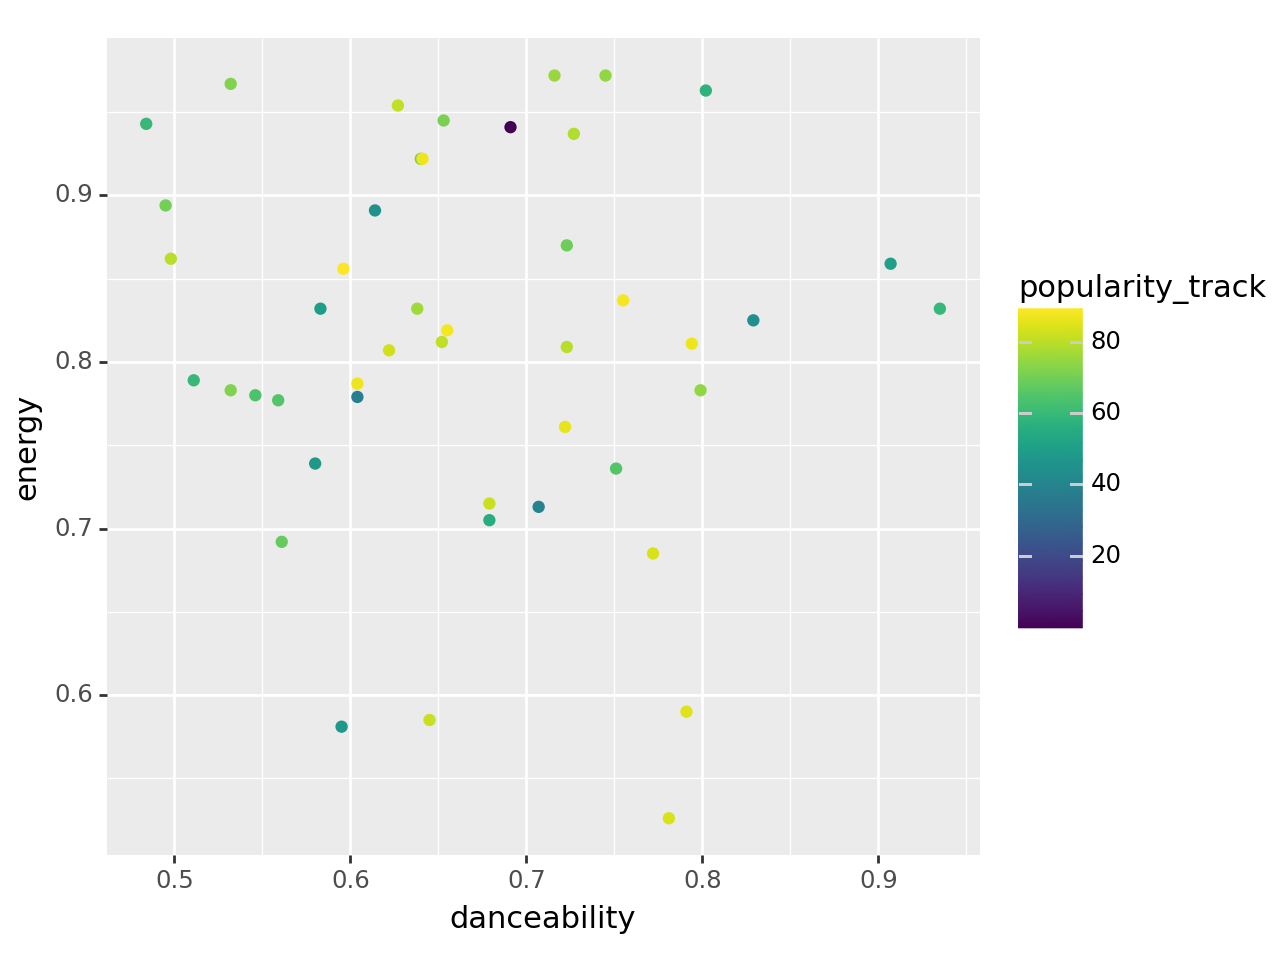

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(songs) +
    aes(x="danceability", y="energy", color="popularity_track") +
    plotnine.geom_point()
)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

d:\Personal\desarrollo\musical_analysis\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
d:\Personal\desarrollo\musical_analysis\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
d:\Personal\desarrollo\musical_analysis\.venv\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ydensity : Removed 93 rows containing non-finite values.


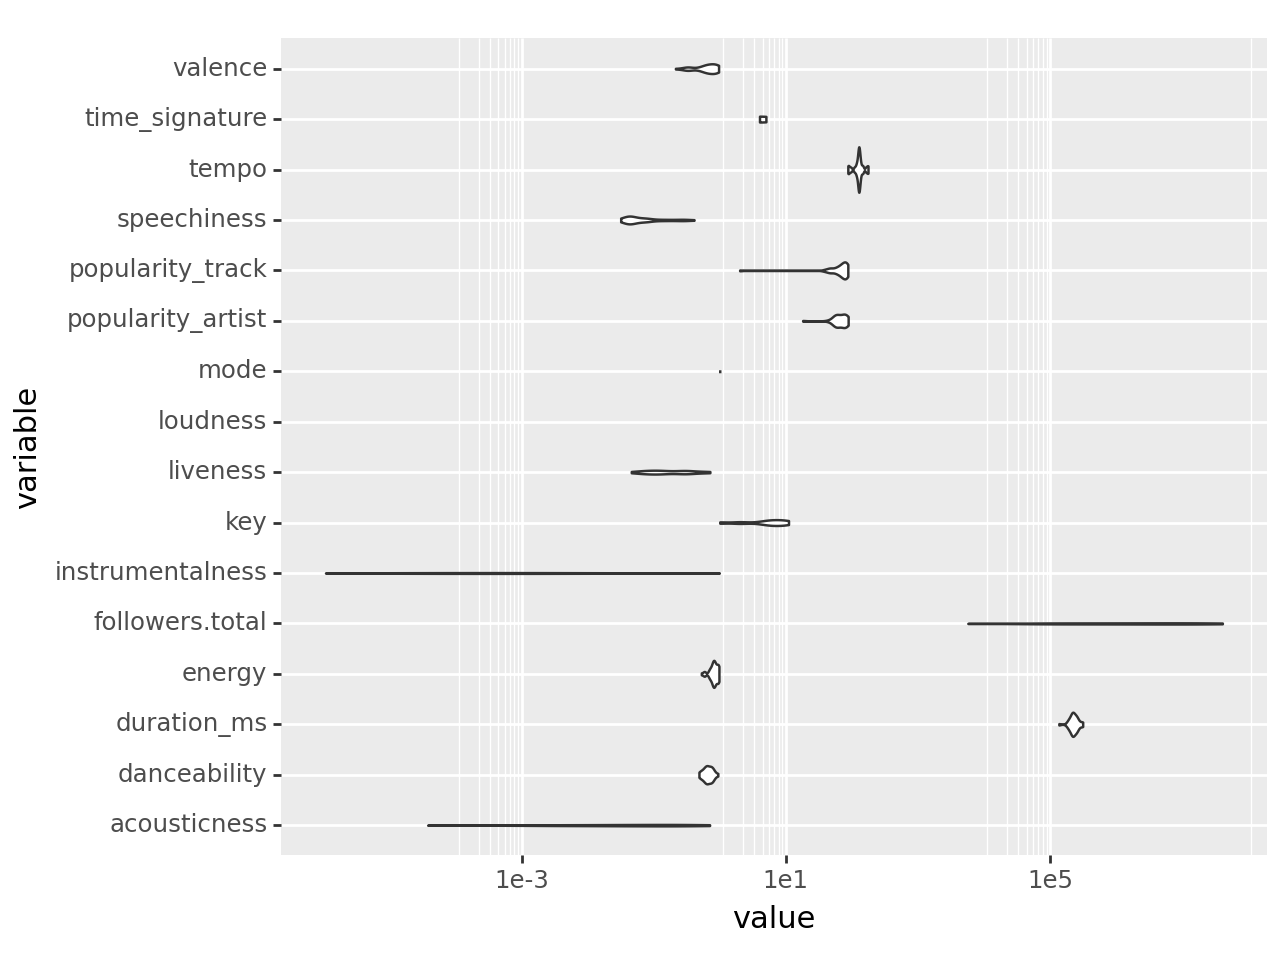

<Figure Size: (640 x 480)>

In [14]:
(
    ggplot(songs.melt(id_vars=("track_name", "artist_name", "album_name", "name"))) +
    aes(x="variable", y="value") +
    plotnine.geom_violin() +
    plotnine.scale_y_log10() +
    plotnine.coord_flip()
)

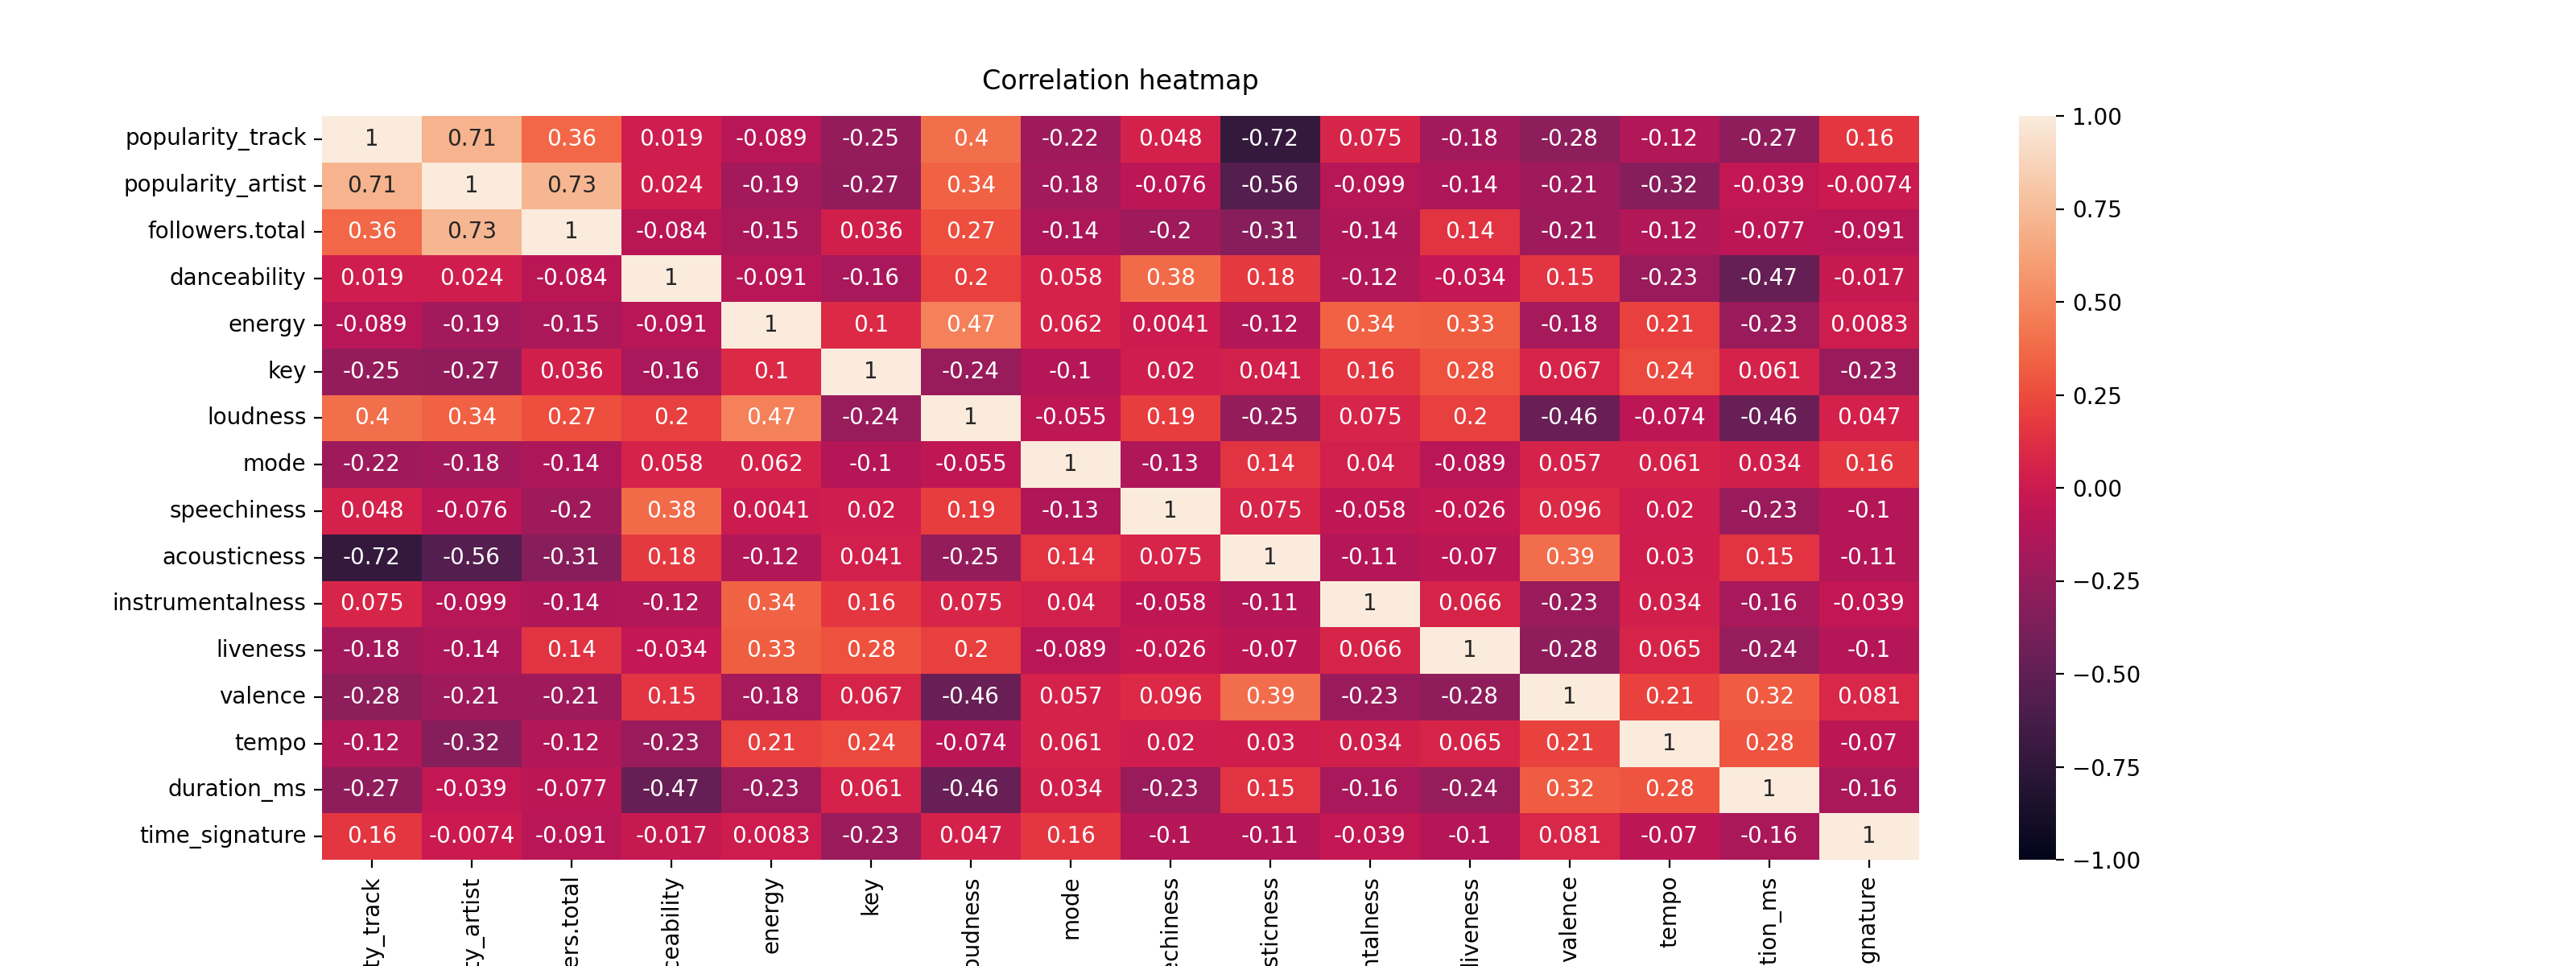

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(song_metrics.corr(), annot=True, vmin=-1, vmax=1)
heatmap.set_title("Correlation heatmap", fontdict={"fontsize":12}, pad=12)
plt.show()

In [16]:
g = sns.PairGrid(song_metrics)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [17]:
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import kmeans_plusplus, KMeans, DBSCAN



In [18]:
X = song_metrics.dropna()

pca = PCA()
pipe = Pipeline([("scaler", StandardScaler()), ("pca", pca)])
Xt = pipe.fit_transform(X)
dfx = pd.DataFrame(Xt)

dfx.shape


(46, 16)

In [19]:
dfx.columns = ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10", "pc11", "pc12", "pc13", "pc14", "pc15", "pc16"]

In [20]:
fig = px.scatter_3d(dfx, x="pc1", y="pc2", z="pc3", color="pc4")
fig.show()

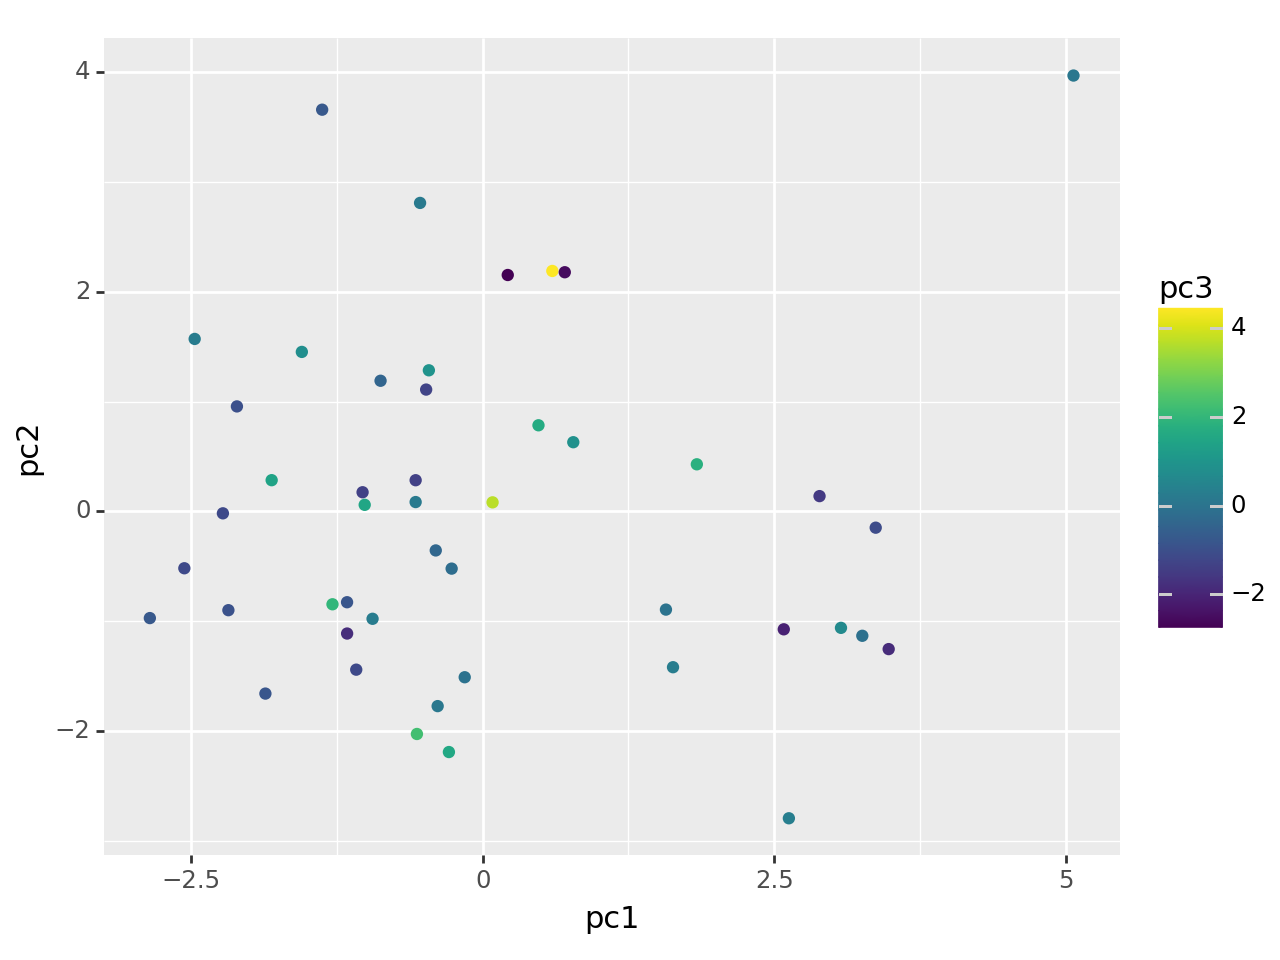

<Figure Size: (640 x 480)>

In [21]:
(
    ggplot(dfx) +
    aes(x="pc1", y="pc2", color="pc3") +
    plotnine.geom_point()
)